In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, models
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                            roc_curve, auc, confusion_matrix, 
                            classification_report)
from sklearn.preprocessing import label_binarize
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


In [ ]:
class Config:
    
    SOURCE_DIR = "PlantVillage"
    DEST_DIR = "./dataset"
    CLASSES = ["Potato___Early_blight", "Potato___Late_blight", "Potato___healthy"]
    CLASS_NAMES = ["Early Blight", "Late Blight", "Healthy"]
       
    BATCH_SIZE = 32
    EPOCHS = 2
    LR = 0.001
    VAL_SPLIT = 0.1
    TEST_SPLIT = 0.1
    
    PLOT_STYLE = "dark_background"
    PALETTE = "viridis"
    
    EARLY_STOPPING_PATIENCE = 3
    LR_SCHEDULER_PATIENCE = 2
    

In [3]:
config = Config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def prepare_dataset():
    """Create dataset directory and copy classes"""
    print("🚀 Preparing dataset...")
    os.makedirs(config.DEST_DIR, exist_ok=True)
    
    for class_name in config.CLASSES:
        src = os.path.join(config.SOURCE_DIR, class_name)
        dst = os.path.join(config.DEST_DIR, class_name)
        
        if os.path.exists(src):
            shutil.copytree(src, dst, dirs_exist_ok=True)
            print(f"  ✓ Copied {class_name} to {dst}")
        else:
            print(f"  ⚠️ Source folder {src} not found!")



In [ ]:
def visualize_dataset(dataset_path):
    """Generate comprehensive dataset visualizations"""
    print("\n🔍 Visualizing dataset...")
    plt.style.use(config.PLOT_STYLE)
    
    
    class_counts = {}
    class_paths = []
    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            count = len(os.listdir(class_dir))
            class_counts[class_name] = count
            class_paths.append(class_dir)
    
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(class_counts.values()), 
                y=list(class_counts.keys()), 
                palette=config.PALETTE)
    plt.title("📊 Class Distribution", fontsize=14)
    plt.xlabel("Number of Images", fontsize=12)
    plt.ylabel("Class", fontsize=12)
    plt.tight_layout()
    plt.savefig("class_distribution.png")
    plt.show()
    
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, class_dir in enumerate(class_paths):
        img_file = os.listdir(class_dir)[0]
        img = Image.open(os.path.join(class_dir, img_file))
        axes[i].imshow(img)
        axes[i].set_title(os.path.basename(class_dir))
        axes[i].axis("off")
    plt.suptitle("🌿 Sample Images from Each Class", fontsize=16)
    plt.tight_layout()
    plt.savefig("sample_images.png")
    plt.show()
    
    
    sizes = []
    for class_dir in class_paths:
        for img_file in os.listdir(class_dir)[:100]:
            with Image.open(os.path.join(class_dir, img_file)) as img:
                sizes.append(img.size)
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=[w for w, h in sizes], y=[h for w, h in sizes], 
                    alpha=0.6, palette=config.PALETTE)
    plt.title("📏 Image Size Distribution", fontsize=14)
    plt.xlabel("Width", fontsize=12)
    plt.ylabel("Height", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("image_sizes.png")
    plt.show()
    

    channel_stats = {'mean': [], 'std': []}
    for class_dir in class_paths:
        for img_file in os.listdir(class_dir)[:50]:
            img = Image.open(os.path.join(class_dir, img_file)).convert('RGB')
            arr = np.array(img) / 255.0
            channel_stats['mean'].append(np.mean(arr, axis=(0, 1)))
            channel_stats['std'].append(np.std(arr, axis=(0, 1)))
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.boxplot(data=channel_stats['mean'], ax=axes[0], palette=config.PALETTE)
    axes[0].set_title("Channel-wise Mean Pixel Values")
    axes[0].set_xticklabels(['Red', 'Green', 'Blue'])
    
    sns.boxplot(data=channel_stats['std'], ax=axes[1], palette=config.PALETTE)
    axes[1].set_title("Channel-wise Standard Deviation")
    axes[1].set_xticklabels(['Red', 'Green', 'Blue'])
    
    plt.suptitle("🎨 Color Channel Statistics", fontsize=16)
    plt.tight_layout()
    plt.savefig("color_stats.png")
    plt.show()
    
    
    mean_rgb = np.mean(channel_stats['mean'], axis=0)
    std_rgb = np.mean(channel_stats['std'], axis=0)
    print(f"\n📊 Dataset Statistics:")
    print(f"  - Mean RGB: {mean_rgb}")
    print(f"  - Std RGB: {std_rgb}")
    print(f"  - Total Images: {sum(class_counts.values())}")
    print(f"  - Classes: {list(class_counts.keys())}")
    
    return mean_rgb, std_rgb


In [ ]:
def create_data_loaders(dataset_path, mean, std):
    """Create data transforms and loaders"""
    print("\n⚙️ Creating data loaders...")
    

    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    

    full_dataset = datasets.ImageFolder(dataset_path, transform=train_transform)
    
    
    val_size = int(config.VAL_SPLIT * len(full_dataset))
    test_size = int(config.TEST_SPLIT * len(full_dataset))
    train_size = len(full_dataset) - val_size - test_size
    
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size]
    )


    val_dataset.dataset.transform = test_transform
    test_dataset.dataset.transform = test_transform
    
    
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, 
                              shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, 
                            shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, 
                             shuffle=False, num_workers=2)
    
    print(f"  ✅ Dataset split:")
    print(f"    - Training: {len(train_dataset)} images")
    print(f"    - Validation: {len(val_dataset)} images")
    print(f"    - Testing: {len(test_dataset)} images")
    
    return train_loader, val_loader, test_loader


In [ ]:
def initialize_model(model_name, num_classes=3):
    """Initialize model with pretrained weights"""
    model = None
    
    if model_name == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "efficientnet":
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == "densenet121":
        model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif model_name == "mobilenet":
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == "custom":
        class CustomCNN(nn.Module):
            def __init__(self):
                super().__init__()
                self.features = nn.Sequential(
                    nn.Conv2d(3, 32, 3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.BatchNorm2d(32),
                    nn.Conv2d(32, 64, 3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.BatchNorm2d(64),
                    nn.Conv2d(64, 128, 3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.BatchNorm2d(128),
                    nn.AdaptiveAvgPool2d((7, 7))
                )
                self.classifier = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(128 * 7 * 7, 512),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(512, num_classes)
                )
            
            def forward(self, x):
                x = self.features(x)
                x = self.classifier(x)
                return x
        model = CustomCNN()
    
    if model:
        print(f"  ✅ Initialized {model_name} model")
        return model.to(device)
    raise ValueError(f"Unknown model name: {model_name}")


In [ ]:
def train_model(model, train_loader, val_loader, model_name):
    """Train model with early stopping and learning rate scheduling"""
    print(f"\n🔥 Training {model_name} model...")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=config.LR_SCHEDULER_PATIENCE, verbose=True
    )
    
    best_val_acc = 0
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(config.EPOCHS):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.EPOCHS}"):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)
        
        train_loss = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        
        val_loss, val_acc = evaluate_model(model, val_loader)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
    
        print(f"  Epoch {epoch+1}: "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
        
    
        scheduler.step(val_loss)
        
    
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), f"{model_name}_best.pth")
            print(f"  🏆 New best model saved! (Accuracy: {val_acc:.2f}%)")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= config.EARLY_STOPPING_PATIENCE:
                print(f"  ⚠️ Early stopping at epoch {epoch+1} (no improvement for {epochs_no_improve} epochs)")
                break
    

    plot_training_history(history, model_name)
    return history


In [ ]:
def evaluate_model(model, loader):
    """Evaluate model performance"""
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss, correct, total = 0, 0, 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def comprehensive_evaluation(model, loader, model_name):
    """Perform comprehensive evaluation with metrics and visualizations"""
    print(f"\n🔬 Evaluating {model_name} model...")
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    

    accuracy = 100 * np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
    precision = 100 * precision_score(y_true, y_pred, average='macro')
    recall = 100 * recall_score(y_true, y_pred, average='macro')
    f1 = 100 * f1_score(y_true, y_pred, average='macro')
    

    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=config.CLASS_NAMES,
                yticklabels=config.CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.tight_layout()
    plt.savefig(f"{model_name}_confusion_matrix.png")
    plt.show()
    

    print("\n📝 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=config.CLASS_NAMES))
    
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
    fpr, tpr, roc_auc = {}, {}, {}
    
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green']
    for i, color in zip(range(3), colors):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], np.array(y_prob)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{config.CLASS_NAMES[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(f"{model_name}_roc_curve.png")
    plt.show()
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': np.mean(list(roc_auc.values()))
    }


In [ ]:
def plot_training_history(history, model_name):
    """Plot training and validation metrics"""
    plt.style.use(config.PLOT_STYLE)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Training & Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Training & Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(f'Training History: {model_name}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f"{model_name}_training_history.png")
    plt.show()

def plot_model_comparison(results):
    """Create comparison visualizations of all models"""
    df = pd.DataFrame.from_dict(results, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Model'}, inplace=True)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='accuracy', data=df, palette=config.PALETTE)
    plt.title('Model Comparison: Test Accuracy', fontsize=16)
    plt.ylabel('Accuracy (%)')
    plt.ylim(80, 100)
    plt.grid(axis='y', alpha=0.3)
    for i, v in enumerate(df['accuracy']):
        plt.text(i, v + 0.5, f"{v:.2f}%", ha='center')
    plt.tight_layout()
    plt.savefig("model_accuracy_comparison.png")
    plt.show()
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    plt.xticks(angles[:-1], metrics)
    plt.ylim(80, 100)
    
    for model, row in df.iterrows():
        values = row[metrics].values.flatten().tolist()
        values += values[:1] 
        ax.plot(angles, values, linewidth=2, linestyle='solid', 
                label=row['Model'])
        ax.fill(angles, values, alpha=0.1)
    
    plt.title('Model Performance Radar Chart', fontsize=16)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.savefig("model_radar_comparison.png")
    plt.show()
    
    print("\n📊 Comprehensive Model Comparison:")
    print(df[['Model', 'accuracy', 'precision', 'recall', 'f1', 'auc']].to_markdown(index=False))


In [ ]:
def train_model(model, train_loader, val_loader, model_name):
    """Train model with early stopping and learning rate scheduling"""
    print(f"\n🔥 Training {model_name} model...")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=config.LR_SCHEDULER_PATIENCE
    )
    
    best_val_acc = 0
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(config.EPOCHS):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.EPOCHS}"):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)
        
        train_loss = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        
        val_loss, val_acc = evaluate_model(model, val_loader)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f"  Epoch {epoch+1}: "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
        
        scheduler.step(val_loss)
        
        current_lr = optimizer.param_groups[0]['lr']
        if current_lr < config.LR:
            print(f"  🔁 Learning rate reduced to {current_lr:.6f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), f"{model_name}_best.pth")
            print(f"  🏆 New best model saved! (Accuracy: {val_acc:.2f}%)")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= config.EARLY_STOPPING_PATIENCE:
                print(f"  ⚠️ Early stopping at epoch {epoch+1} (no improvement for {epochs_no_improve} epochs)")
                break
    
    
    plot_training_history(history, model_name)
    return history

🚀 Preparing dataset...
  ✓ Copied Potato___Early_blight to ./dataset\Potato___Early_blight
  ✓ Copied Potato___Late_blight to ./dataset\Potato___Late_blight
  ✓ Copied Potato___healthy to ./dataset\Potato___healthy

🔍 Visualizing dataset...


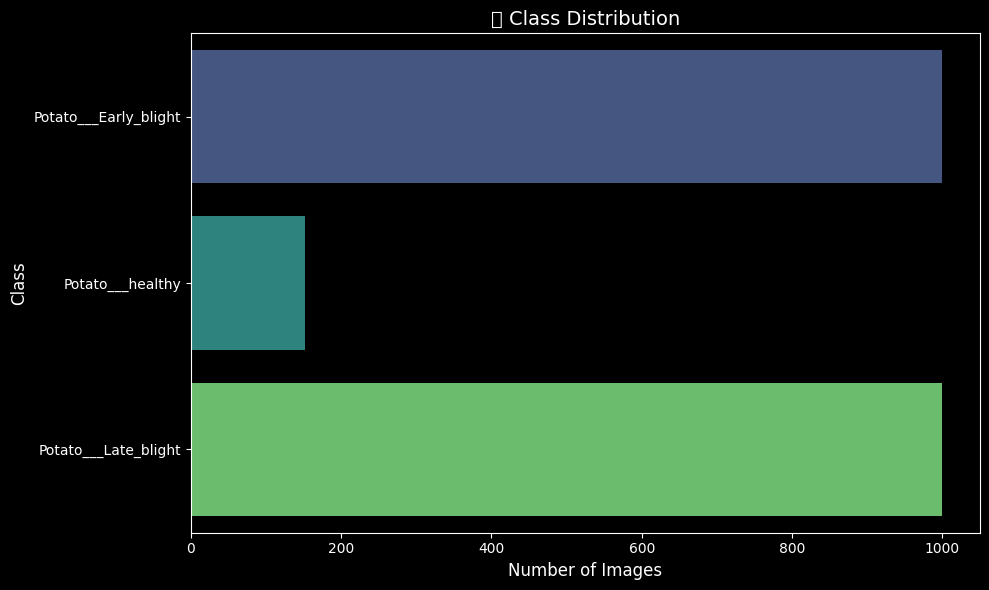

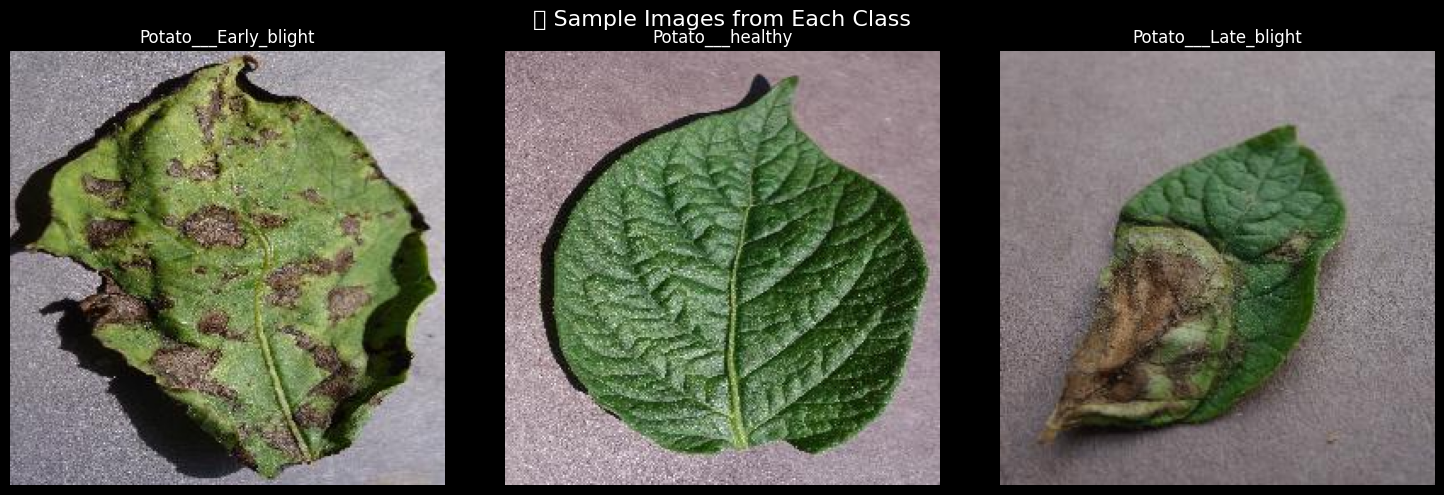

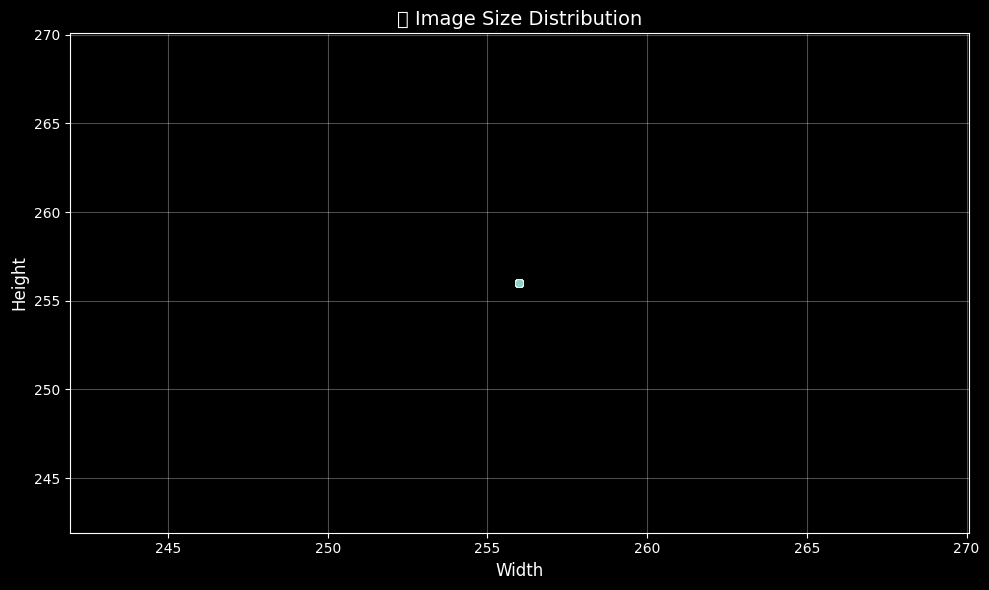

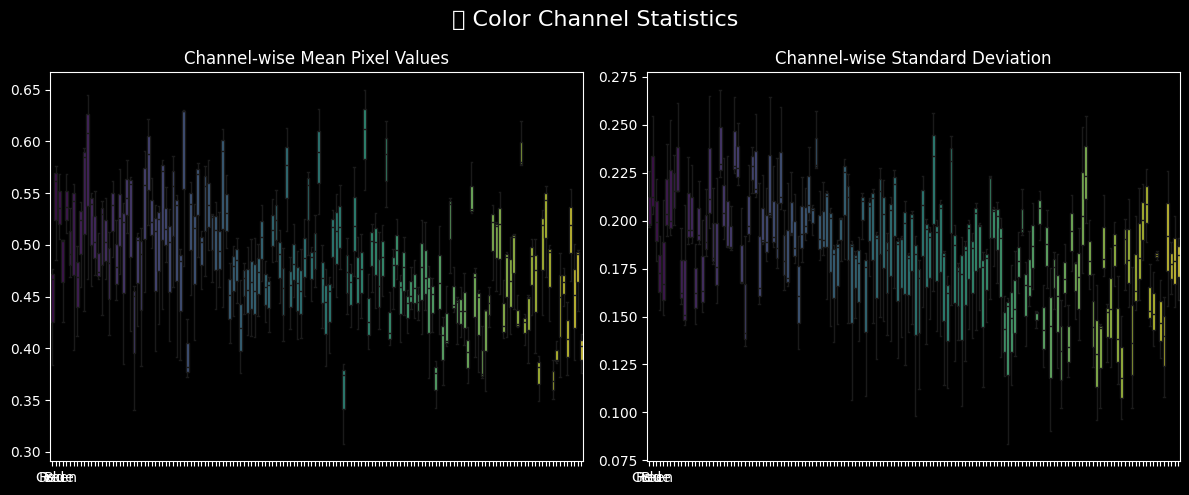


📊 Dataset Statistics:
  - Mean RGB: [0.49178789 0.51102228 0.43462071]
  - Std RGB: [0.18429859 0.1572768  0.20592659]
  - Total Images: 2152
  - Classes: ['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']

⚙️ Creating data loaders...
  ✅ Dataset split:
    - Training: 1722 images
    - Validation: 215 images
    - Testing: 215 images
  ✅ Initialized densenet121 model

🔥 Training densenet121 model...


Epoch 1/2: 100%|██████████| 54/54 [07:13<00:00,  8.03s/it]


  Epoch 1: Train Loss: 0.1366, Acc: 95.47% | Val Loss: 0.0621, Acc: 98.14%
  🏆 New best model saved! (Accuracy: 98.14%)


Epoch 2/2: 100%|██████████| 54/54 [06:59<00:00,  7.78s/it]


  Epoch 2: Train Loss: 0.0444, Acc: 98.49% | Val Loss: 0.1447, Acc: 94.88%


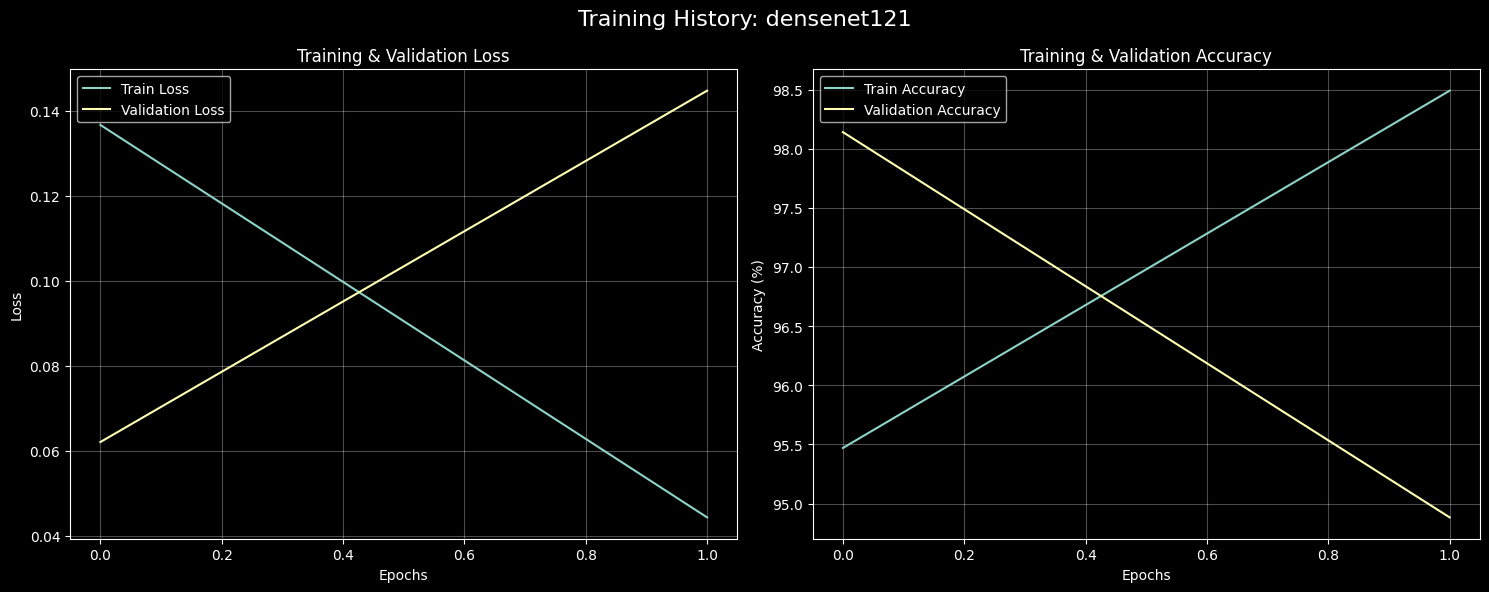


🔬 Evaluating densenet121 model...


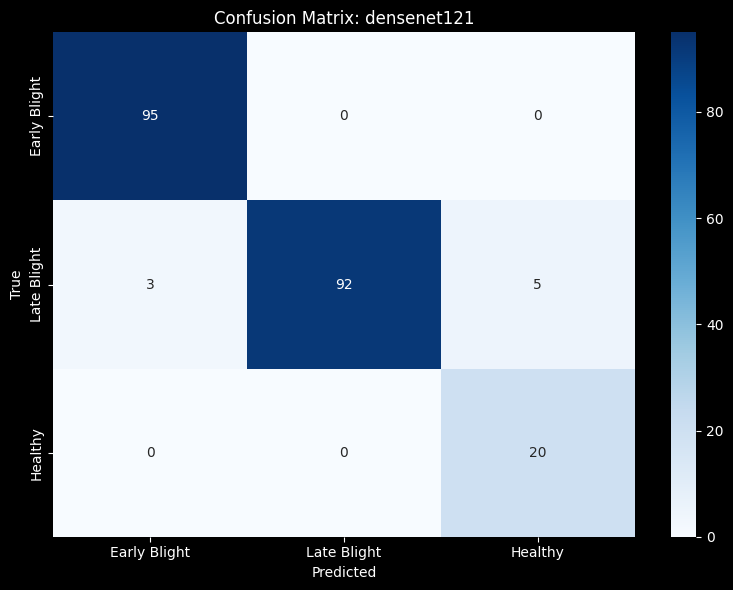


📝 Classification Report:
              precision    recall  f1-score   support

Early Blight       0.97      1.00      0.98        95
 Late Blight       1.00      0.92      0.96       100
     Healthy       0.80      1.00      0.89        20

    accuracy                           0.96       215
   macro avg       0.92      0.97      0.94       215
weighted avg       0.97      0.96      0.96       215



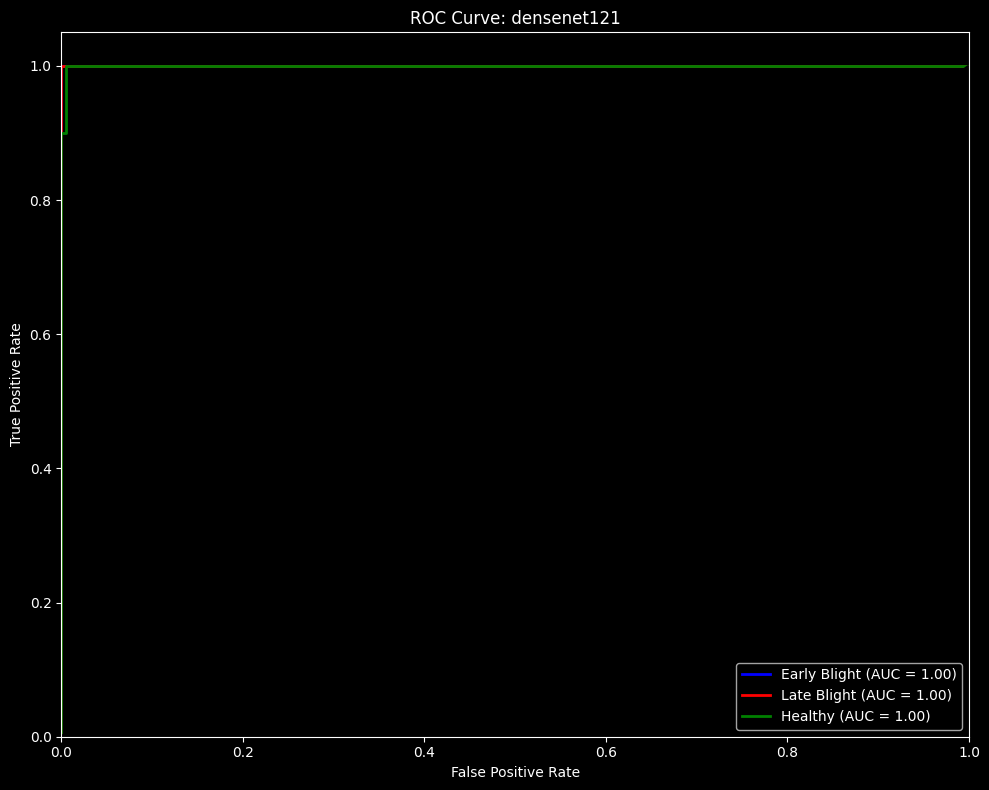


📊 densenet121 Final Test Performance:
  - Accuracy: 96.28%
  - Precision: 92.31%
  - Recall: 97.33%
  - F1-Score: 94.39%
  - AUC: 1.00%
  ✅ Initialized efficientnet model

🔥 Training efficientnet model...


Epoch 1/2: 100%|██████████| 54/54 [03:03<00:00,  3.40s/it]


  Epoch 1: Train Loss: 0.1564, Acc: 95.53% | Val Loss: 0.0024, Acc: 100.00%
  🏆 New best model saved! (Accuracy: 100.00%)


Epoch 2/2: 100%|██████████| 54/54 [03:02<00:00,  3.39s/it]


  Epoch 2: Train Loss: 0.0237, Acc: 99.25% | Val Loss: 0.0173, Acc: 99.53%


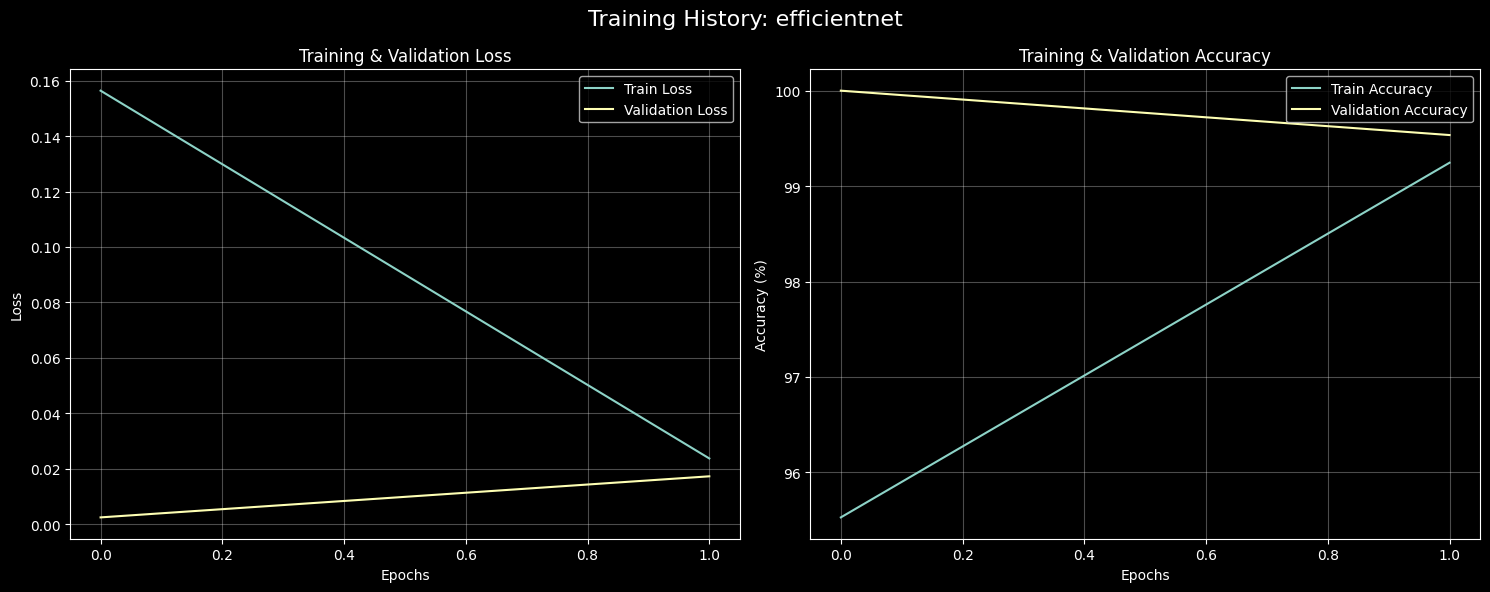


🔬 Evaluating efficientnet model...


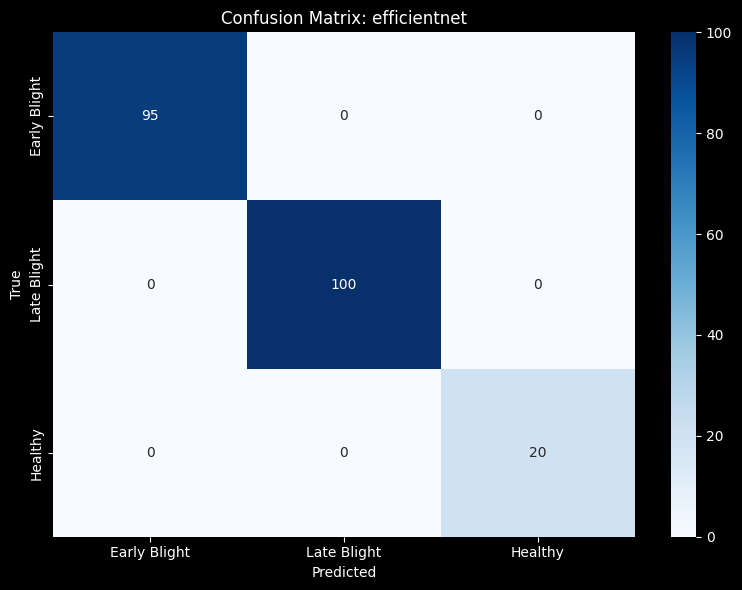


📝 Classification Report:
              precision    recall  f1-score   support

Early Blight       1.00      1.00      1.00        95
 Late Blight       1.00      1.00      1.00       100
     Healthy       1.00      1.00      1.00        20

    accuracy                           1.00       215
   macro avg       1.00      1.00      1.00       215
weighted avg       1.00      1.00      1.00       215



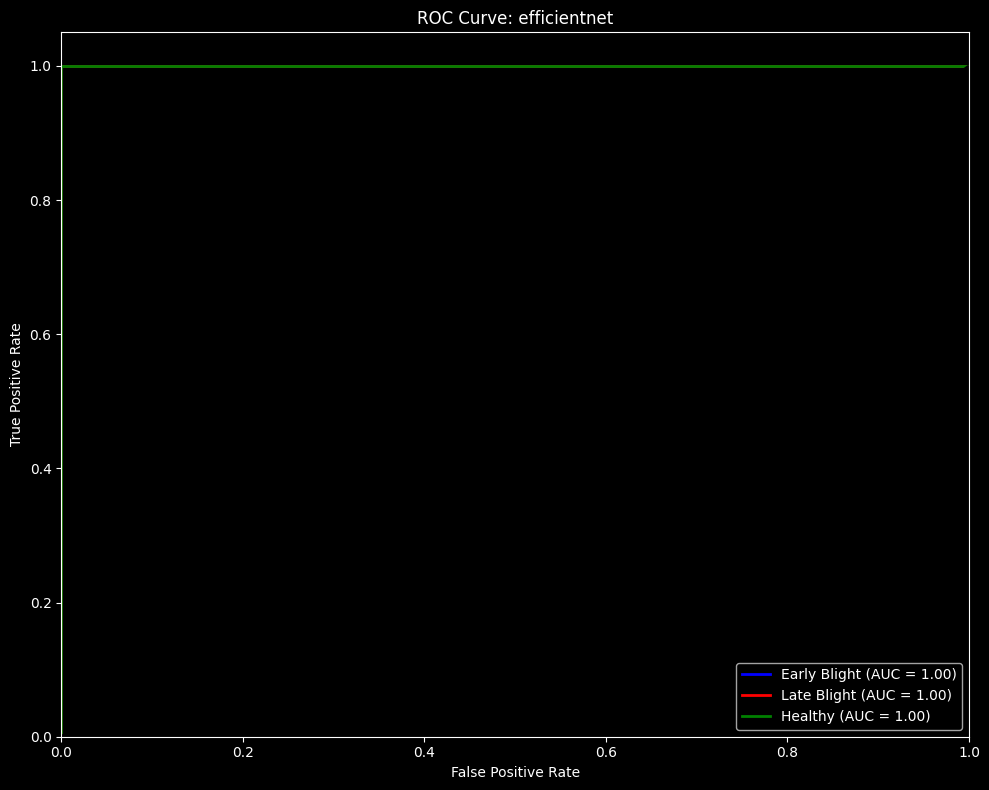


📊 efficientnet Final Test Performance:
  - Accuracy: 100.00%
  - Precision: 100.00%
  - Recall: 100.00%
  - F1-Score: 100.00%
  - AUC: 1.00%
  ✅ Initialized resnet50 model

🔥 Training resnet50 model...


Epoch 1/2: 100%|██████████| 54/54 [07:27<00:00,  8.29s/it]


  Epoch 1: Train Loss: 0.1859, Acc: 94.48% | Val Loss: 0.1094, Acc: 97.67%
  🏆 New best model saved! (Accuracy: 97.67%)


Epoch 2/2: 100%|██████████| 54/54 [10:02<00:00, 11.16s/it]


  Epoch 2: Train Loss: 0.0324, Acc: 99.01% | Val Loss: 0.0150, Acc: 99.07%
  🏆 New best model saved! (Accuracy: 99.07%)


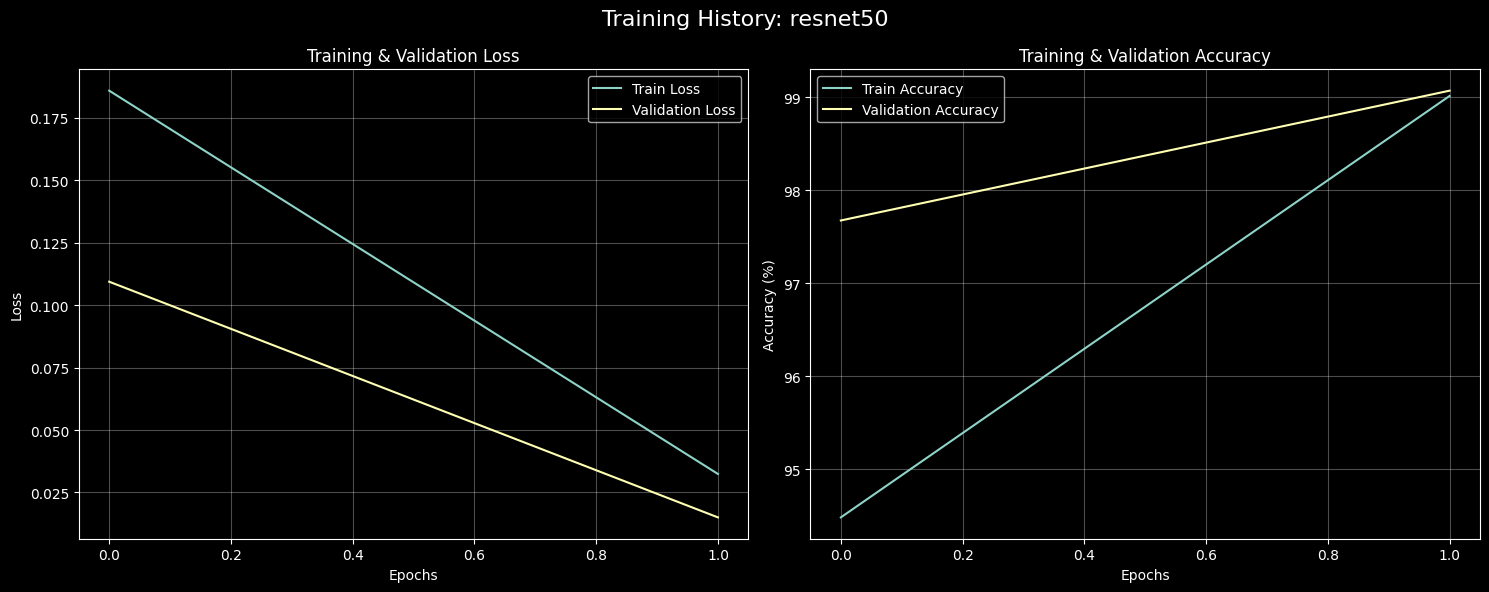


🔬 Evaluating resnet50 model...


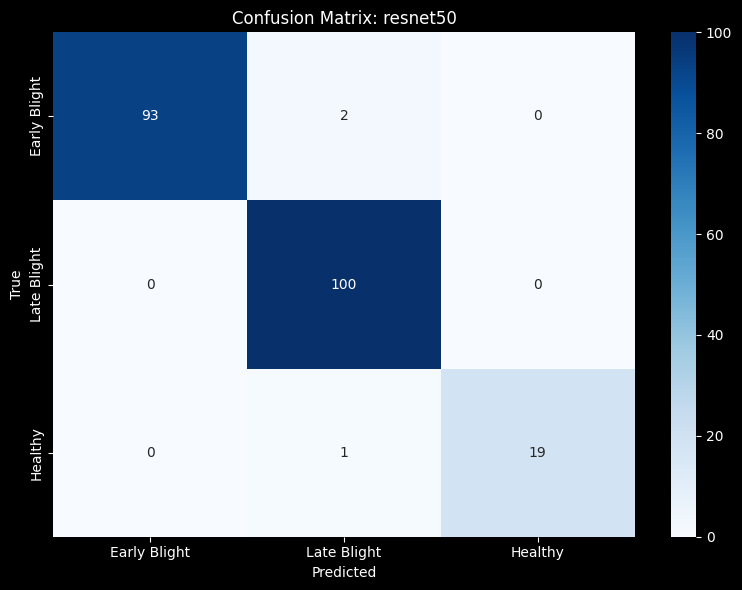


📝 Classification Report:
              precision    recall  f1-score   support

Early Blight       1.00      0.98      0.99        95
 Late Blight       0.97      1.00      0.99       100
     Healthy       1.00      0.95      0.97        20

    accuracy                           0.99       215
   macro avg       0.99      0.98      0.98       215
weighted avg       0.99      0.99      0.99       215



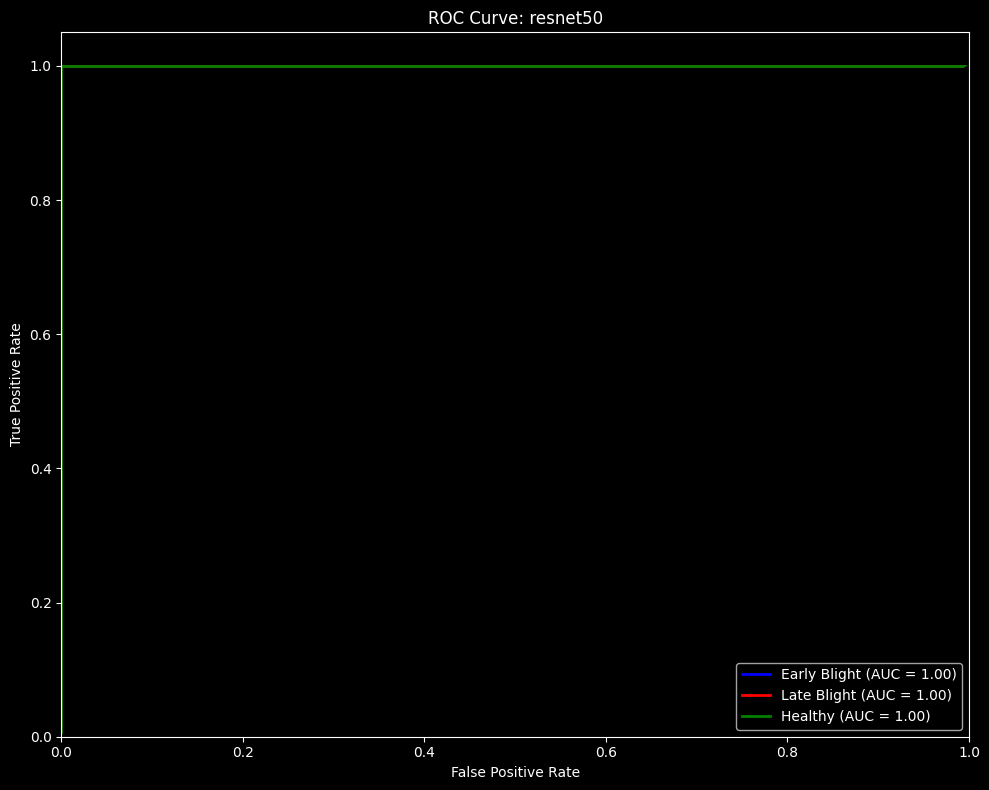


📊 resnet50 Final Test Performance:
  - Accuracy: 98.60%
  - Precision: 99.03%
  - Recall: 97.63%
  - F1-Score: 98.30%
  - AUC: 1.00%
  ✅ Initialized mobilenet model

🔥 Training mobilenet model...


Epoch 1/2: 100%|██████████| 54/54 [02:16<00:00,  2.53s/it]


  Epoch 1: Train Loss: 0.1351, Acc: 95.76% | Val Loss: 0.0275, Acc: 99.07%
  🏆 New best model saved! (Accuracy: 99.07%)


Epoch 2/2: 100%|██████████| 54/54 [02:28<00:00,  2.76s/it]


  Epoch 2: Train Loss: 0.0259, Acc: 99.01% | Val Loss: 0.0095, Acc: 100.00%
  🏆 New best model saved! (Accuracy: 100.00%)


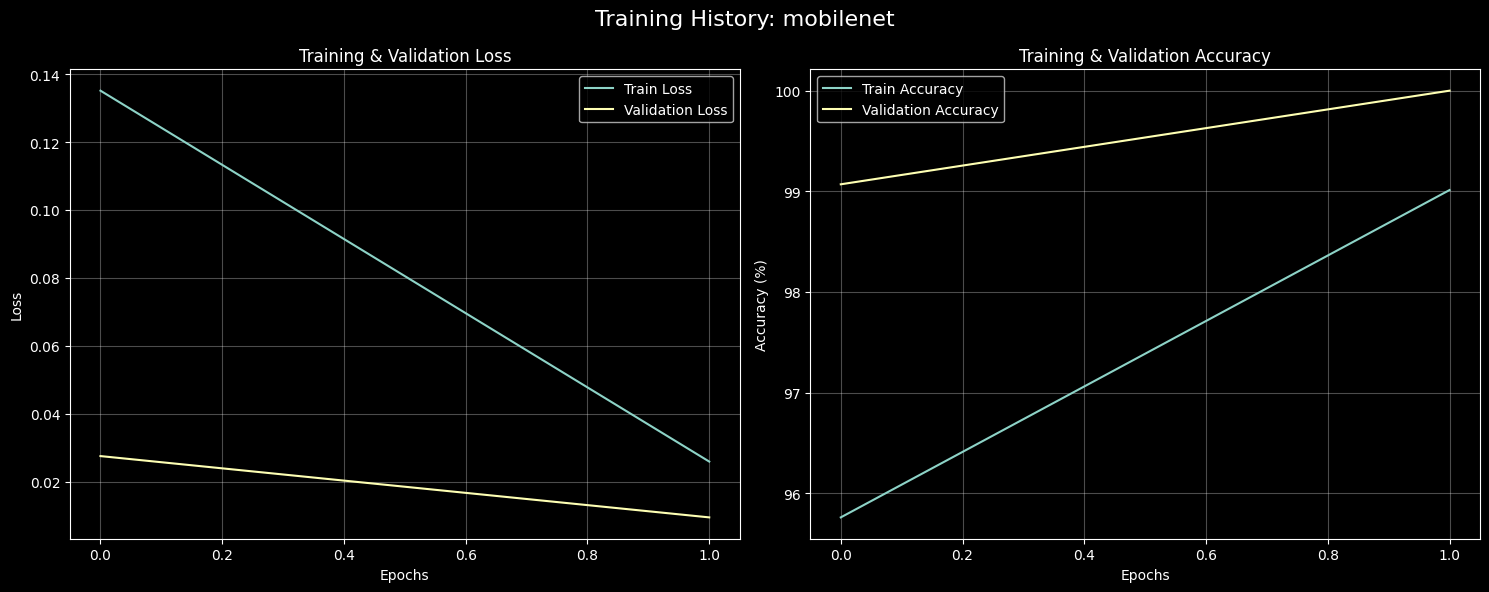


🔬 Evaluating mobilenet model...


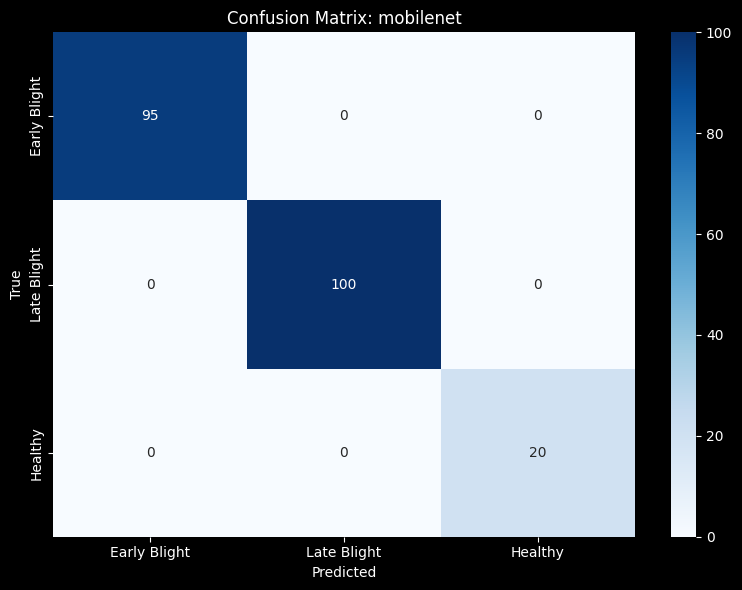


📝 Classification Report:
              precision    recall  f1-score   support

Early Blight       1.00      1.00      1.00        95
 Late Blight       1.00      1.00      1.00       100
     Healthy       1.00      1.00      1.00        20

    accuracy                           1.00       215
   macro avg       1.00      1.00      1.00       215
weighted avg       1.00      1.00      1.00       215



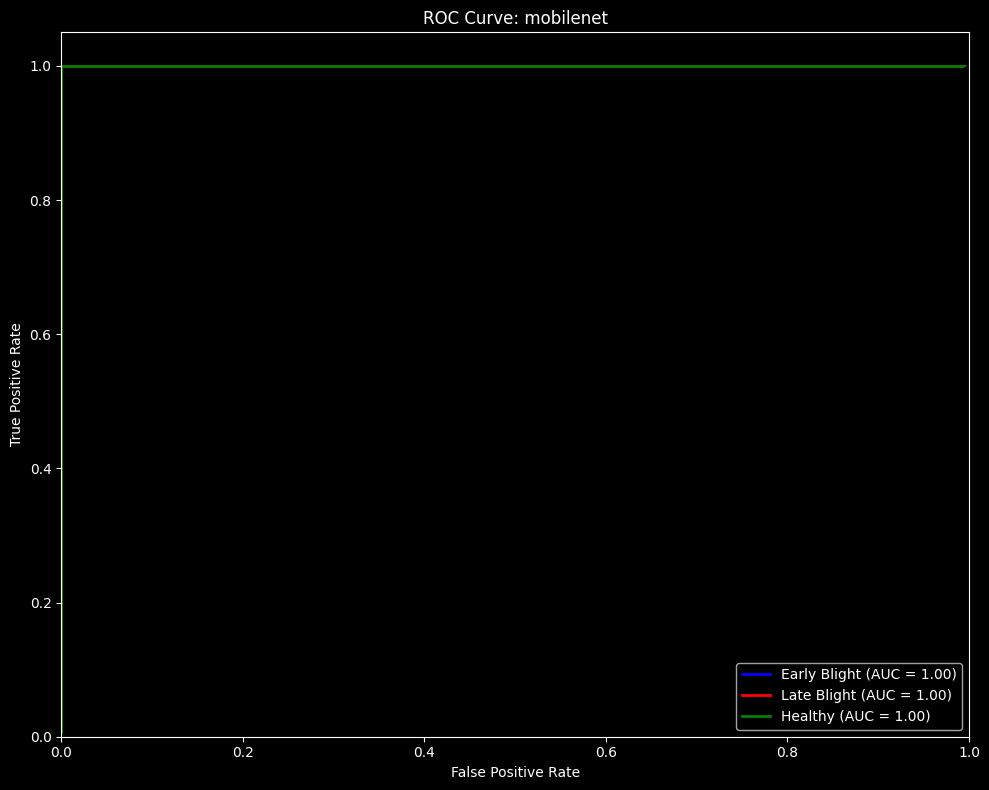


📊 mobilenet Final Test Performance:
  - Accuracy: 100.00%
  - Precision: 100.00%
  - Recall: 100.00%
  - F1-Score: 100.00%
  - AUC: 1.00%
  ✅ Initialized resnet18 model

🔥 Training resnet18 model...


Epoch 1/2: 100%|██████████| 54/54 [03:00<00:00,  3.34s/it]


  Epoch 1: Train Loss: 0.1790, Acc: 93.61% | Val Loss: 0.2588, Acc: 93.02%
  🏆 New best model saved! (Accuracy: 93.02%)


Epoch 2/2: 100%|██████████| 54/54 [03:00<00:00,  3.34s/it]


  Epoch 2: Train Loss: 0.0427, Acc: 98.66% | Val Loss: 0.3122, Acc: 85.58%


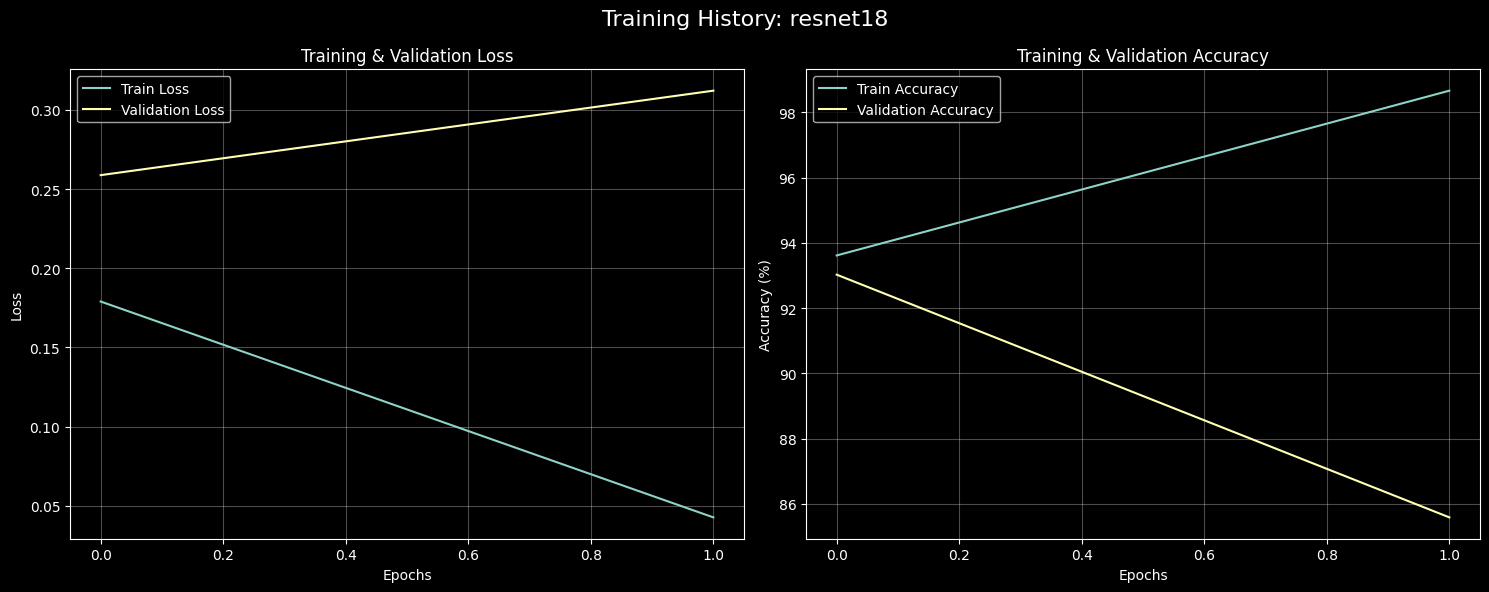


🔬 Evaluating resnet18 model...


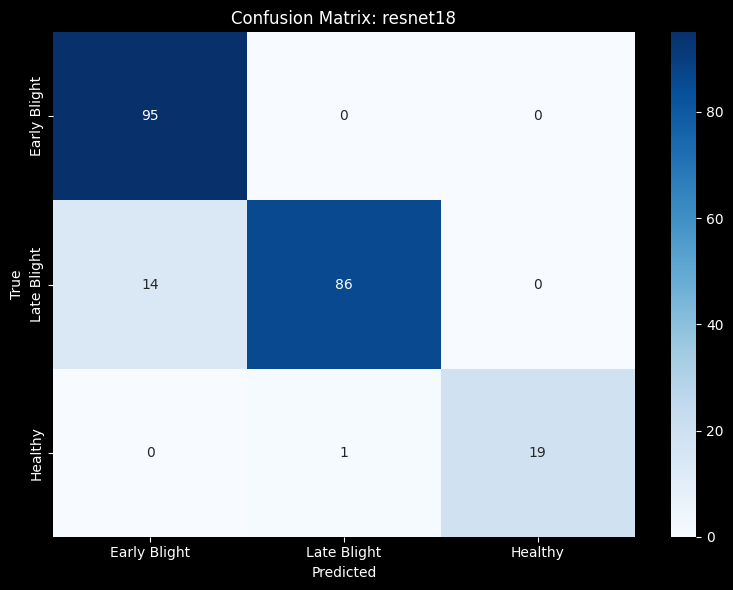


📝 Classification Report:
              precision    recall  f1-score   support

Early Blight       0.87      1.00      0.93        95
 Late Blight       0.99      0.86      0.92       100
     Healthy       1.00      0.95      0.97        20

    accuracy                           0.93       215
   macro avg       0.95      0.94      0.94       215
weighted avg       0.94      0.93      0.93       215



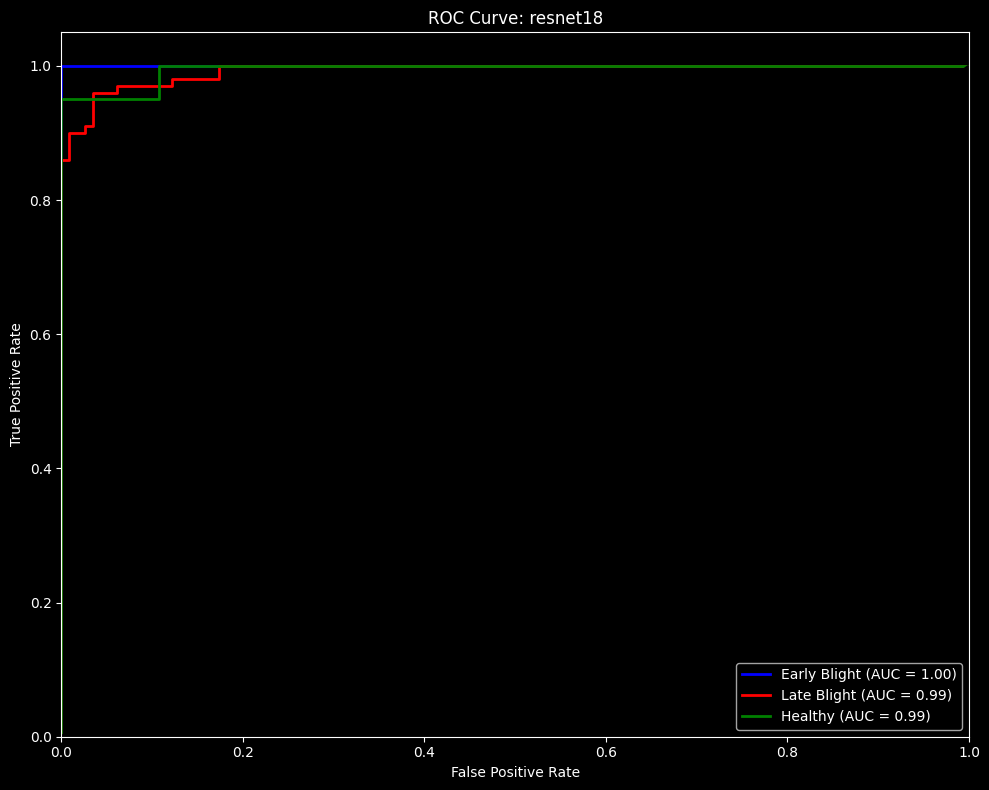


📊 resnet18 Final Test Performance:
  - Accuracy: 93.02%
  - Precision: 95.34%
  - Recall: 93.67%
  - F1-Score: 94.18%
  - AUC: 1.00%
  ✅ Initialized custom model

🔥 Training custom model...


Epoch 1/2: 100%|██████████| 54/54 [01:33<00:00,  1.73s/it]


  Epoch 1: Train Loss: 0.2203, Acc: 92.51% | Val Loss: 0.1353, Acc: 94.42%
  🏆 New best model saved! (Accuracy: 94.42%)


Epoch 2/2: 100%|██████████| 54/54 [01:33<00:00,  1.72s/it]


  Epoch 2: Train Loss: 0.1523, Acc: 95.53% | Val Loss: 0.0834, Acc: 96.74%
  🏆 New best model saved! (Accuracy: 96.74%)


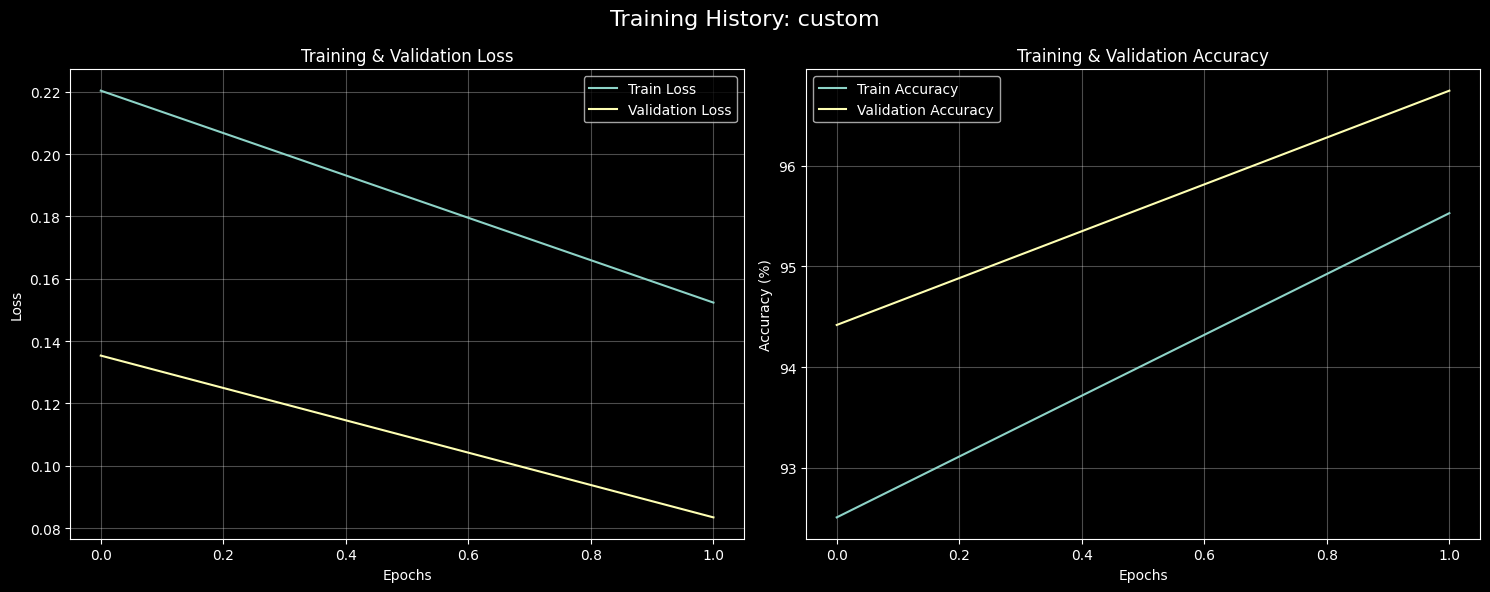


🔬 Evaluating custom model...


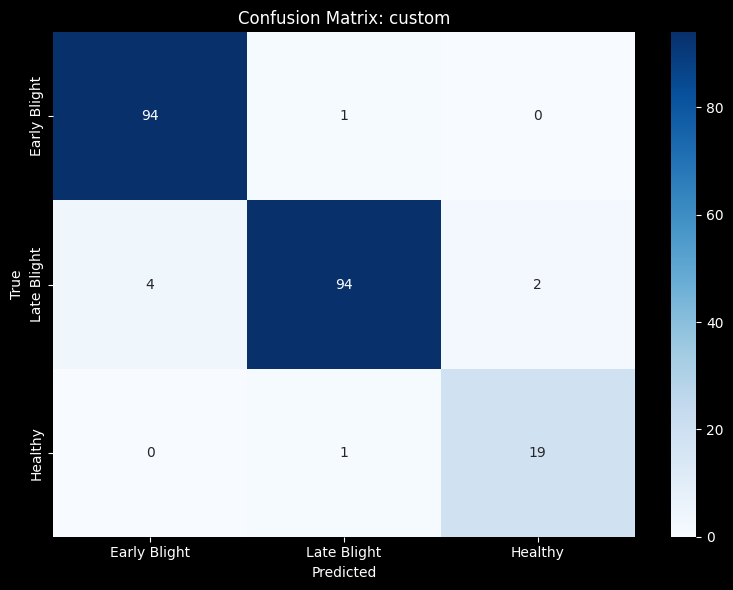


📝 Classification Report:
              precision    recall  f1-score   support

Early Blight       0.96      0.99      0.97        95
 Late Blight       0.98      0.94      0.96       100
     Healthy       0.90      0.95      0.93        20

    accuracy                           0.96       215
   macro avg       0.95      0.96      0.95       215
weighted avg       0.96      0.96      0.96       215



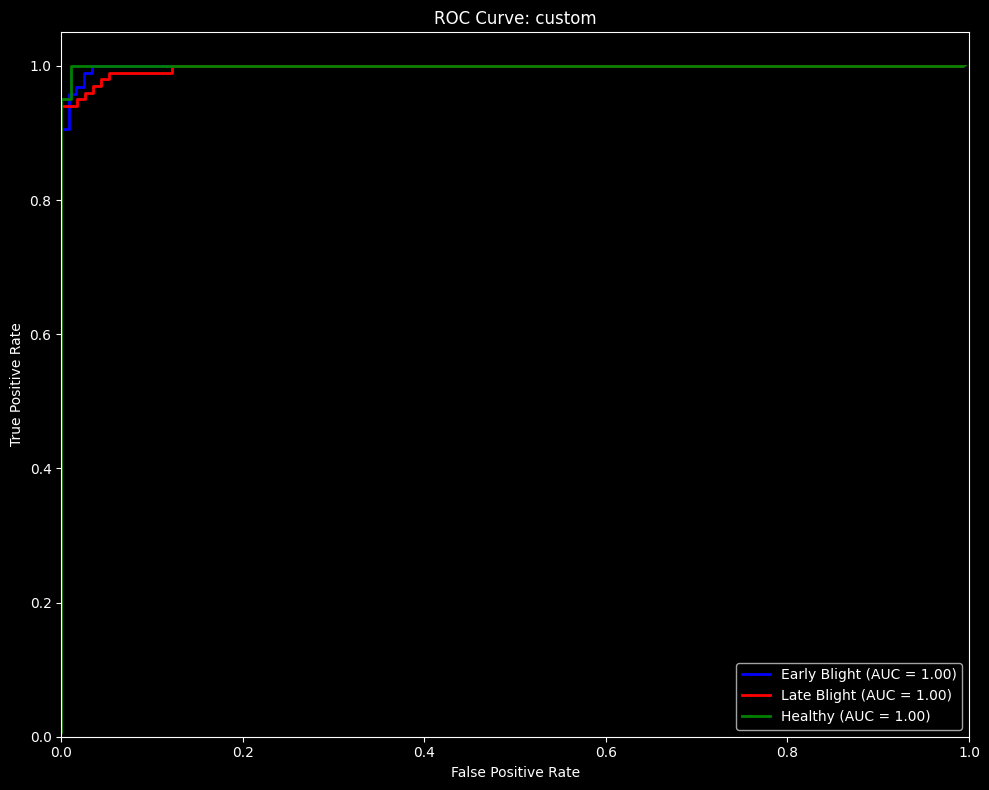


📊 custom Final Test Performance:
  - Accuracy: 96.28%
  - Precision: 94.77%
  - Recall: 95.98%
  - F1-Score: 95.34%
  - AUC: 1.00%


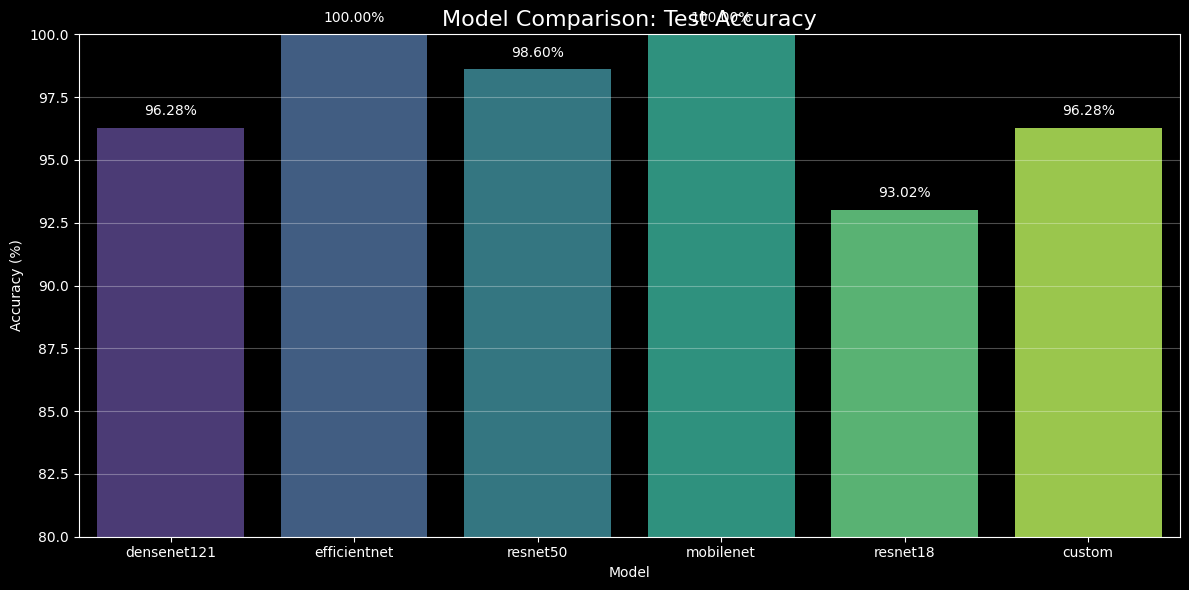

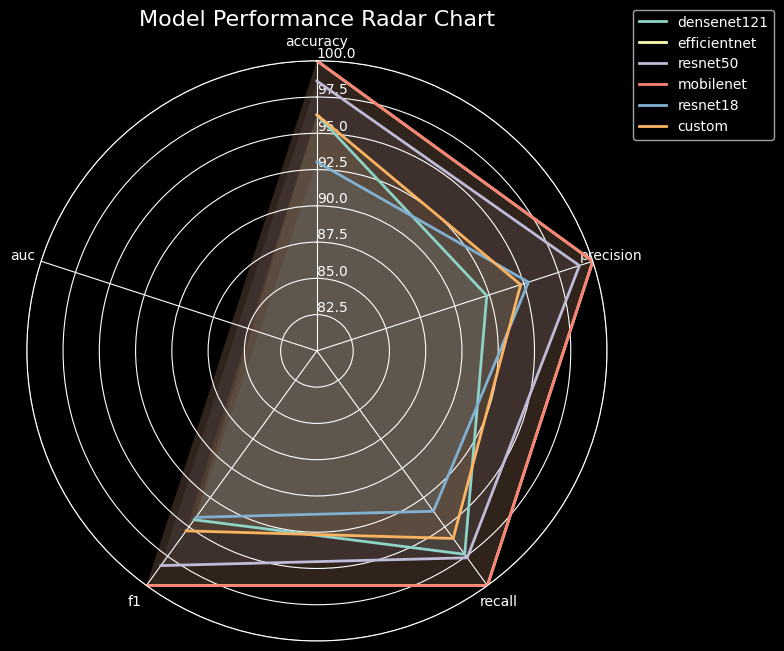


📊 Comprehensive Model Comparison:
| Model        |   accuracy |   precision |   recall |       f1 |      auc |
|:-------------|-----------:|------------:|---------:|---------:|---------:|
| densenet121  |    96.2791 |     92.3129 |  97.3333 |  94.3893 | 0.999829 |
| efficientnet |   100      |    100      | 100      | 100      | 1        |
| resnet50     |    98.6047 |     99.0291 |  97.6316 |  98.2981 | 1        |
| mobilenet    |   100      |    100      | 100      | 100      | 1        |
| resnet18     |    93.0233 |     95.3355 |  93.6667 |  94.1839 | 0.995654 |
| custom       |    96.2791 |     94.7704 |  95.9825 |  95.3369 | 0.998346 |

🏆 Best Model: efficientnet (100.00% accuracy)
✅ Training and evaluation complete!


In [ ]:
if __name__ == "__main__":

    prepare_dataset()
    

    mean_rgb, std_rgb = visualize_dataset(config.DEST_DIR)
    

    train_loader, val_loader, test_loader = create_data_loaders(
        config.DEST_DIR, mean_rgb, std_rgb
    )
    
    
    models_to_test = [
        "densenet121",
        "efficientnet",
        "resnet50",
        "mobilenet",
        "resnet18",
        "custom"
    ]
    
    results = {}
    
    
    for model_name in models_to_test:
        
        model = initialize_model(model_name, num_classes=3)
        
        
        history = train_model(model, train_loader, val_loader, model_name)
        
        
        model.load_state_dict(torch.load(f"{model_name}_best.pth"))
        
        
        metrics = comprehensive_evaluation(model, test_loader, model_name)
        results[model_name] = metrics
        
        
        print(f"\n📊 {model_name} Final Test Performance:")
        print(f"  - Accuracy: {metrics['accuracy']:.2f}%")
        print(f"  - Precision: {metrics['precision']:.2f}%")
        print(f"  - Recall: {metrics['recall']:.2f}%")
        print(f"  - F1-Score: {metrics['f1']:.2f}%")
        print(f"  - AUC: {metrics['auc']:.2f}%")
    

    plot_model_comparison(results)
    
    best_model_name = max(results, key=lambda k: results[k]['accuracy'])
    print(f"\n🏆 Best Model: {best_model_name} ({results[best_model_name]['accuracy']:.2f}% accuracy)")
    print("✅ Training and evaluation complete!")